In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read input data into df
df = pd.read_csv("./data/bank/bank-full.csv", delimiter =";")

In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [4]:
# Rename output column tosomething more meaningful
df1 = df.rename(columns = {'y': 'decision'})

# Label distribution
df1['decision'].value_counts()

no     39922
yes     5289
Name: decision, dtype: int64

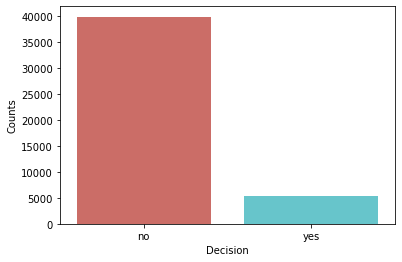

In [5]:
# Plot label distribution
import seaborn as sns
sns.countplot(x='decision', data = df1, palette = 'hls')
plt.xlabel('Decision')
plt.ylabel('Counts')
plt.show()

In [6]:
# Inspect All numeric columns
df_numeric = df1.select_dtypes(exclude='object')
df_numeric.head()
df_numeric.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


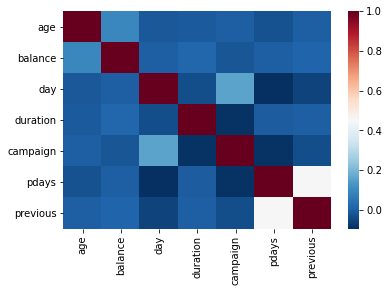

In [7]:
# Plot the correlation
df_numeric_corr = df_numeric.corr()
sns.heatmap(df_numeric_corr, cbar=True, cmap="RdBu_r")
plt.show()

In [8]:
# Move decision to separate df
df_label = df1['decision'].map({'yes':1, 'no':0})

# drop features
df2 = df1.drop(columns = ['decision', 'duration', 'poutcome'], axis=1)


In [9]:
# Convert categorical values to numeric
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

df_with_dummy = pd.get_dummies(df2, columns = cat_vars)
df_with_dummy.shape

(45211, 46)

In [10]:
# Prepare data for train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_with_dummy, df_label, test_size = 0.25, stratify = df_label)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((33908, 46), (11303, 46), (33908,), (11303,))

In [11]:
# Build Pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from  sklearn.preprocessing import StandardScaler

pipeline = Pipeline(
    [
        ('standard_sclaer', StandardScaler()),
        ('decision_tree', DecisionTreeClassifier())
    ]
)
pipeline

Pipeline(memory=None,
         steps=[('standard_sclaer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [12]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

# Find the best hyper parameters (criterion,max_depth) for the decision tree
hyper_params = {
    'decision_tree__criterion' :['gini', 'entropy'],
    'decision_tree__max_depth' : np.arange(3,15),
    'decision_tree__max_features': np.arange(5,20)
}

for folds in tqdm(range(3,6)):
    grid = GridSearchCV(pipeline, param_grid = hyper_params, cv = folds)
    
    # Fit grid with training data and labels
    grid.fit(X_train, y_train)
    
    # score with test data and labels
    score = grid.score(X_test, y_test)
    
    print("Cv: ", folds, "Score: ", score)
    print("Best hyper params: ", grid.best_params_)
    print("Best model ", grid.best_estimator_)

<ipython-input-12-1f90fecc8f22>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for folds in tqdm(range(3,6)):


Cv:  3 Score:  0.8830399009112625
Best hyper params:  {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 6, 'decision_tree__max_features': 16}
Best model  Pipeline(memory=None,
         steps=[('standard_sclaer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=6,
                                        max_features=16, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose

In [47]:
# Choose the best hyper params for the model based on the above cell
dt  = DecisionTreeClassifier(criterion='gini',max_depth = 7)
dt.fit(X_train, y_train)
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

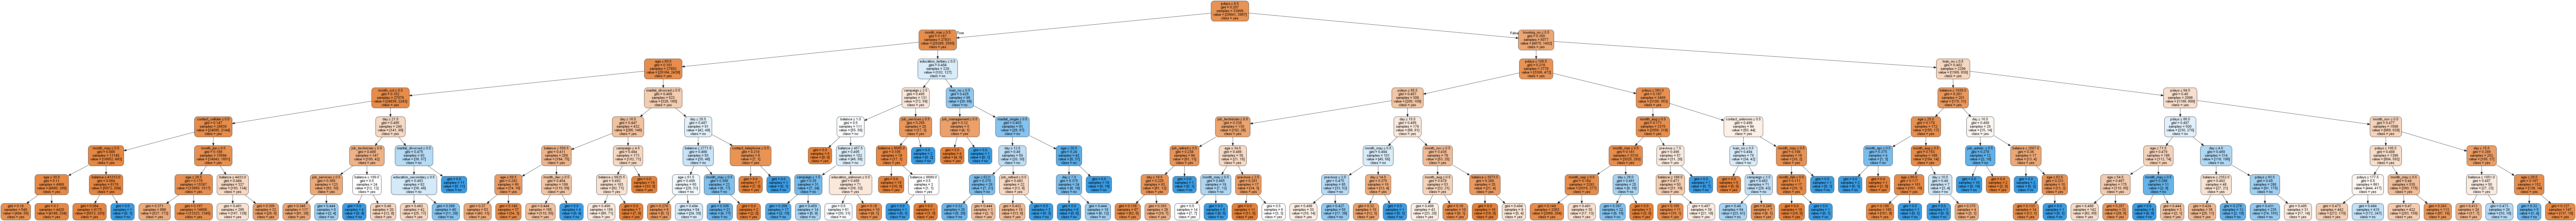

In [48]:
# Plot the tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data  = StringIO()

# Filter month columns to fit the graph on screen

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns, class_names=['yes','no'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('Bank_DecsT.png',)
Image(graph.create_png())

In [49]:
# Run predictions and measure test accuracy
from sklearn import metrics

y_predict = dt.predict(X_test)
score =metrics.accuracy_score(y_test, y_predict)
print(score)

0.8848978147394497
